<a href="https://colab.research.google.com/github/giamberinigiulia/SPE_Project/blob/main/models/CTMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

In [94]:
def simulate_ctmc(Q, initial_state, t_max):
    """
    Simulate a single sample path of a continuous-time Markov chain.
    """
    num_states = Q.shape[0]
    times = [0]
    states = [initial_state]
    current_state = initial_state
    current_time = 0

    while current_time < t_max:
        rates = Q[current_state]
        exit_rate = -rates[current_state]
        if exit_rate == 0:
            break

        holding_time = np.random.exponential(1 / exit_rate)
        current_time += holding_time
        if current_time >= t_max:
            break

        transition_probabilities = rates / exit_rate
        transition_probabilities[current_state] = 0
        transition_probabilities /= np.sum(transition_probabilities)

        next_state = np.random.choice(len(Q), p=transition_probabilities)

        times.append(current_time)
        states.append(next_state)
        current_state = next_state

    return times, states

def average_state_probabilities(Q, initial_state, t_max, N):
    """
    Perform N independent simulations and compute average state probabilities
    across 100 equally spaced time points.
    """
    num_states = Q.shape[0]
    t_points = np.linspace(0, t_max, 100)
    avg_probabilities = np.zeros((100, num_states))
    state_counts = np.zeros((N, 100, num_states)) #Added this line

    for n in range(N):
        times, states = simulate_ctmc(Q, initial_state, t_max)
        state_idx = 0

        for i, t in enumerate(t_points):
            while state_idx < len(times) - 1 and times[state_idx + 1] <= t:
                state_idx += 1

            current_state = states[state_idx]
            avg_probabilities[i, current_state] += 1
            state_counts[n, i, current_state] += 1  # Count visits for CI

    avg_probabilities /= N

    return t_points, avg_probabilities, state_counts

def forward_equations(Q, t_max, initial_state_probs):
    """
    Solve the forward Kolmogorov equations (dπ/dt = Q * π) numerically.

    Parameters:
    Q (numpy.ndarray): The rate (generator) matrix of the CTMC.
    t_max (float): The total time for the simulation.
    initial_state_probs (numpy.ndarray): Initial state probability distribution.

    Returns:
    t_points (numpy.ndarray): Array of 100 equally spaced time points.
    probabilities (numpy.ndarray): Matrix of probabilities for each state at each time point.
    """
    num_states = Q.shape[0]
    t_points = np.linspace(0, t_max, 100)

    def ode_system(t, pi):
        return Q.T @ pi

    # Solve the system of ODEs using an initial condition
    solution = solve_ivp(ode_system, [0, t_max], initial_state_probs, t_eval=t_points)

    return t_points, solution.y.T

def perform_simulation(Q, initial_state, t_max, N):
    print(f"Running with N = {N}")

    # Measure time for stochastic simulation
    start_time_sim = time.time()
    t_points_sim, avg_probabilities_sim = average_state_probabilities(Q, initial_state, t_max, N)
    end_time_sim = time.time()
    sim_duration = end_time_sim - start_time_sim
    print(f"Stochastic simulation took {sim_duration:.4f} seconds.")

    # Measure time for numerical solution of forward equations
    initial_state_probs = np.zeros(Q.shape[0])
    initial_state_probs[initial_state] = 1.0  # Start with 100% probability in the initial state

    start_time_forward = time.time()
    t_points_forward, probabilities_forward = forward_equations(Q, t_max, initial_state_probs)
    end_time_forward = time.time()
    forward_duration = end_time_forward - start_time_forward
    print(f"Numerical solution of forward equations took {forward_duration:.4f} seconds.")

    # Plot the results for comparison
    for state in range(avg_probabilities_sim.shape[1]):
        plt.plot(t_points_sim, avg_probabilities_sim[:, state], label=f"Simulated State {state}", linestyle='--')
        plt.plot(t_points_forward, probabilities_forward[:, state], label=f"Forward Eq. State {state}")

    plt.xlabel('Time')
    plt.ylabel('State Probabilities')
    plt.title('State Probabilities: Simulation vs Forward Equations')
    plt.legend()
    plt.show()



In [95]:
def compute_forward_equations(Q, initial_state, t_max):
    initial_state_probs = np.zeros(Q.shape[0])
    initial_state_probs[initial_state] = 1.0  # Start with 100% probability in the initial state

    #start_time_forward = time.time()
    t_points_forward, probabilities_forward = forward_equations(Q, t_max, initial_state_probs)
    #end_time_forward = time.time()
    #forward_duration = end_time_forward - start_time_forward
    #print(f"Numerical solution of forward equations took {forward_duration:.4f} seconds.")
    return t_points_forward, probabilities_forward

In [96]:
def get_usage(Q, initial_state, t_max):
    t_points_forward, probabilities_forward = compute_forward_equations(Q, initial_state, t_max)
    return t_points_forward, np.sum(probabilities_forward[:, 1:], axis=1)

In [97]:
def get_queue_client_number(Q, client_number, initial_state, t_max):
    t_points_forward, probabilities_forward = compute_forward_equations(Q, initial_state, t_max)
    return t_points_forward, probabilities_forward[:, :] @ client_number

In [98]:
def plot_usage(Q_rnd, Q_fifo, client_number, client_number_1, initial_state, t_max):
    t_points_forward, usage = get_usage(Q_rnd, initial_state, t_max)
    plt.plot(t_points_forward, usage, label="Forward Eq. rnd")
    t_points_forward, usage = get_usage(Q_fifo, initial_state, t_max)
    plt.plot(t_points_forward, usage, label="Forward Eq. FIFO")

    plt.xlabel('Time')
    plt.ylabel('Usage')
    plt.title('Usage over time: rnd vs FIFO')
    plt.legend()
    plt.show()

    t_points_forward, queue_client_number = get_queue_client_number(Q_rnd, client_number, initial_state, t_max)
    plt.plot(t_points_forward, queue_client_number, label="Forward Eq. rnd")
    t_points_forward, queue_client_number = get_queue_client_number(Q_fifo, client_number_1, initial_state, t_max)
    plt.plot(t_points_forward, queue_client_number, label="Forward Eq. FIFO")

    plt.xlabel('Time')
    plt.ylabel('Waiting users')
    plt.title('Waiting users over time: rnd vs FIFO')
    plt.show()

In [99]:
def plot_throughput(Q_rnd, Q_fifo, initial_state, t_max, mu):
  t_points_forward, probabilities_forward = compute_forward_equations(Q_rnd, initial_state, t_max)
  plt.plot(t_points_forward, mu*(1-probabilities_forward[:,0]), label='Forward Eq. rnd')
  t_points_forward, probabilities_forward = compute_forward_equations(Q_fifo, initial_state, t_max)
  plt.plot(t_points_forward, mu*(1-probabilities_forward[:,0]), label='Forward Eq. FIFO')
  plt.xlabel('Time')
  plt.ylabel('Throughput')
  plt.title('Throughput: rnd vs FIFO')
  plt.legend()
  plt.show()

In [100]:
def plot_std(Q, client_number, initial_state, t_max):
  t_points_forward, mean = get_queue_client_number(Q, client_number, initial_state, t_max)
  t_points_forward, mean2 = get_queue_client_number(Q, np.power(client_number, 2), initial_state, t_max)
  std = np.sqrt(mean2 - np.power(mean, 2))
  plt.plot(t_points_forward, mean, label='mean')
  plt.plot(t_points_forward, mean + std, label='mean + std')
  plt.plot(t_points_forward, mean - std, label='mean - std')
  plt.legend()
  plt.show()

In [101]:
def plot_confidence_intervals(Q, initial_state, t_max, N):
  t_points_sim, mean_probabilities, state_counts_sim = average_state_probabilities(Q, initial_state, t_max, N)
  std_probabilities = state_counts_sim.std(axis=0) / np.sqrt(N)
  conf_intervals = 1.96 * std_probabilities  # 95% CI

  plt.figure(figsize=(12, 8))
  for state in range(Q.shape[0]):
    plt.plot(t_points_sim, mean_probabilities[:, state], label=f'State {state}')
    plt.fill_between(t_points_sim,
                     mean_probabilities[:, state] - conf_intervals[:, state],
                     mean_probabilities[:, state] + conf_intervals[:, state],
                     alpha=0.3)

  plt.title('Average State Probabilities with 95% Confidence Intervals')
  plt.xlabel('Time')
  plt.ylabel('Probability')
  plt.legend()
  plt.grid()
  plt.show()

In [102]:
def add_assorbing_state(Q, j):
  matrix_size = (Q.shape[0] + 1, Q.shape[1] + 1)
  Q_as = np.zeros(matrix_size)
  Q_as[:-1, :-1] = Q

  for i in range(Q_as.shape[0] - 1):
    if (i != j):
      Q_as[i, -1] = Q_as[i, j]
      Q_as[i, j] = 0

  return Q_as

In [103]:
def plot_mean_first_passage_time(Q, initial_state, j_state, t_max):
  Q_as = add_assorbing_state(Q, j_state)
  t_points_forward, probabilities_forward = compute_forward_equations(Q_as, initial_state, t_max)

  plt.plot(t_points_forward, np.sum(probabilities_forward[:, -1:], axis=1))
  plt.xlabel('Time')
  plt.ylabel('MFPT')
  plt.title('MFPT from s'+ str(initial_state) + ' to s' + str(j_state))
  plt.show()

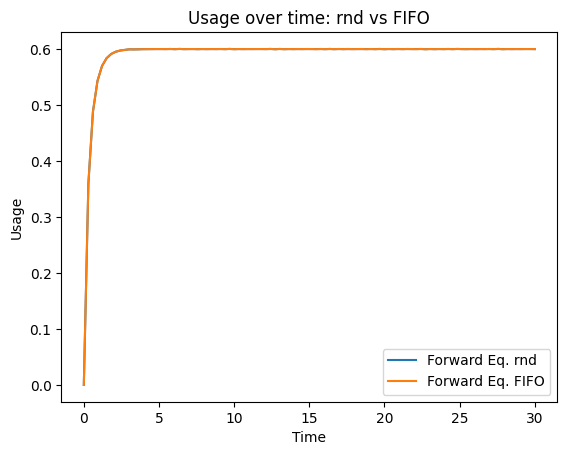

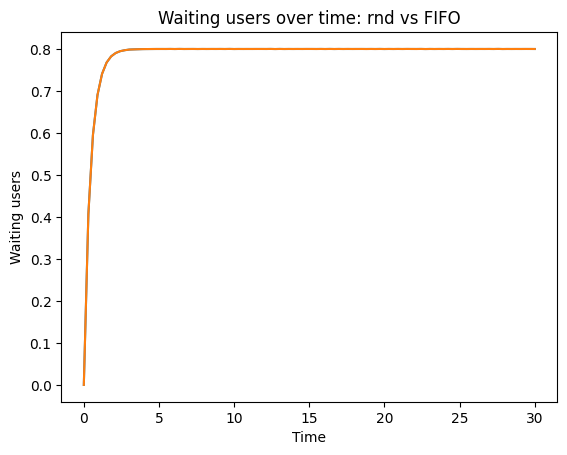

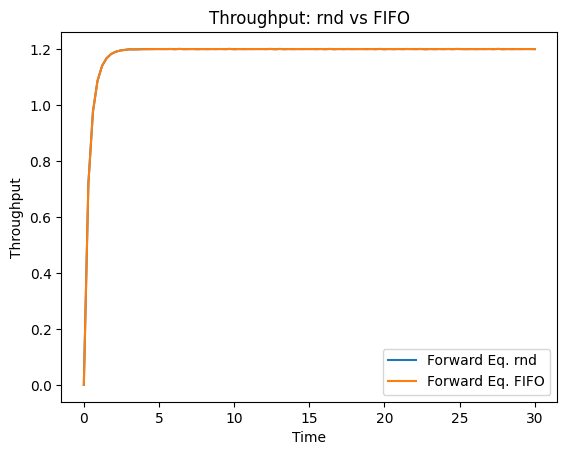

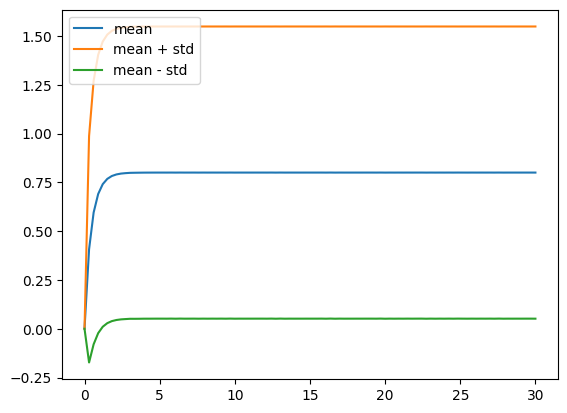

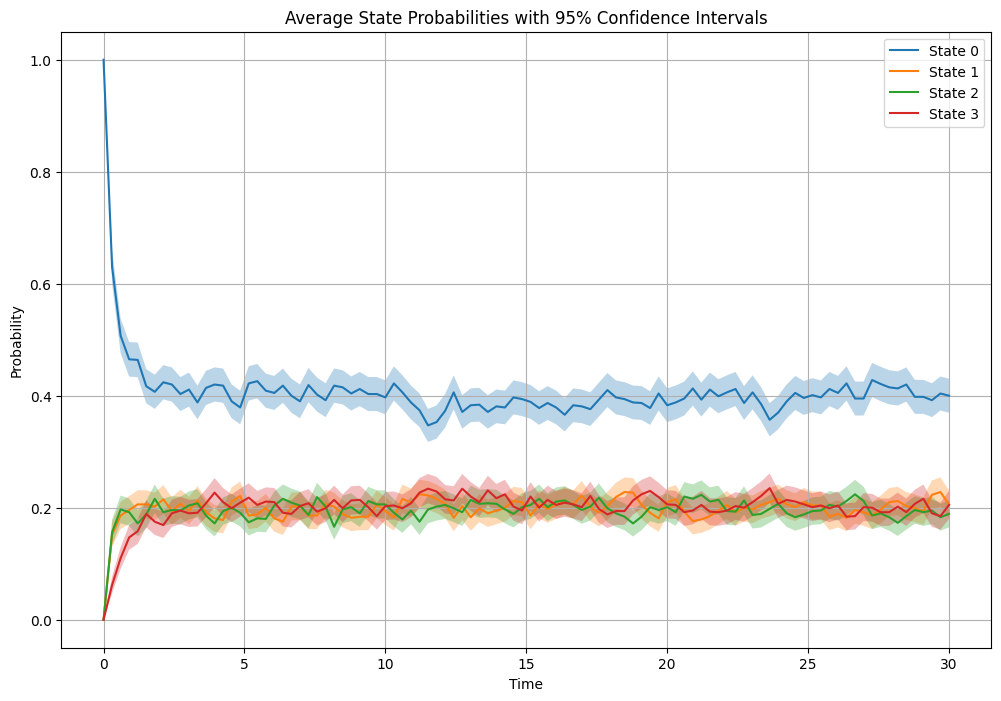


Q rnd:


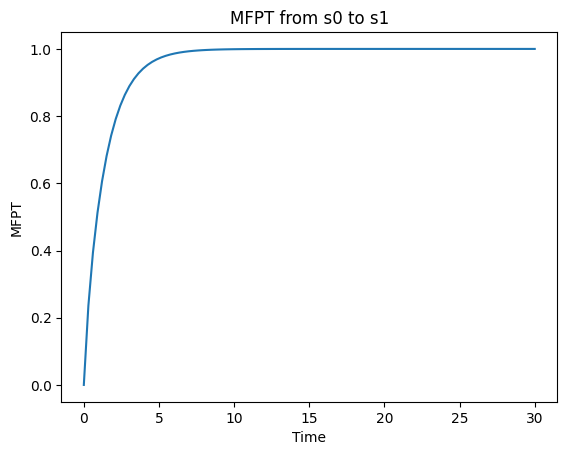


Q fifo:


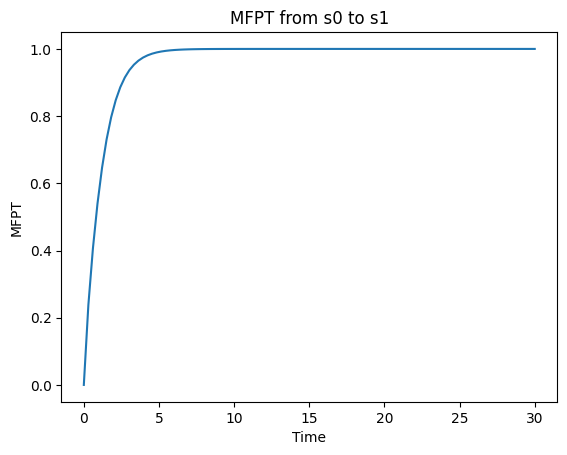

In [104]:
enter_rate = 1
serving_rate = 2

Q_rnd = np.array([
    [-(2*enter_rate), enter_rate, enter_rate, 0.0],
    [serving_rate, -(serving_rate + enter_rate), 0.0, enter_rate],
    [serving_rate, 0.0, -(serving_rate + enter_rate), enter_rate],
    [0.0, serving_rate/2, serving_rate/2, -serving_rate],
])

client_number = [0, 1, 1, 2]

Q_fifo = np.array([
    [-(2*enter_rate), enter_rate, enter_rate, 0.0, 0.0],
    [serving_rate, -(serving_rate + enter_rate), 0.0, enter_rate, 0.0],
    [serving_rate, 0.0, -(serving_rate + enter_rate), 0.0, enter_rate],
    [0.0, 0.0, serving_rate, -serving_rate, 0.0],
    [0.0, serving_rate, 0.0, 0.0, -serving_rate],
])

client_number_1 = [0, 1, 1, 2, 2]

initial_state = 0
t_max = 30
j_state_rnd = 1
j_state_fifo = 1

plot_usage(Q_rnd, Q_fifo, client_number, client_number_1, initial_state, t_max)
plot_throughput(Q_rnd, Q_fifo, initial_state, t_max, serving_rate)
plot_std(Q_rnd, client_number, initial_state, t_max)
plot_confidence_intervals(Q_rnd, initial_state, t_max, 1000)
print('\nQ rnd:')
plot_mean_first_passage_time(Q_rnd, initial_state, j_state_rnd, t_max)
print('\nQ fifo:')
plot_mean_first_passage_time(Q_fifo, initial_state, j_state_fifo, t_max)